In [ ]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# 加载原始数据
data = pd.read_csv('H:\FYP\SC\signal_metrics.csv')
#新增 Locality 列
data = data[['Timestamp', 'Network Type', 'Data Throughput (Mbps)', 'Locality']]
#选择需要的列：Timestamp 和 Data Throughput (Mbps)
# data = data[['Timestamp', 'Network Type', 'Data Throughput (Mbps)']]
#确保 Timestamp 列是时间格式
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# 设置 Timestamp 为索引
data.set_index('Timestamp', inplace=True)

# data = pd.get_dummies(data, columns=['Network Type'], drop_first=True)
# 对 Network Type 进行独热编码
data = pd.get_dummies(data, columns=['Network Type'], drop_first=True)

# 对 Locality 进行独热编码
data = pd.get_dummies(data, columns=['Locality'], drop_first=True)

# 查看数据的前几行
print(data.head())

检查是否存在缺失值，并进行处理（比如填充或删除）。
确保 Data Throughput (Mbps) 是数值型。

In [2]:
# 过滤出 Network Type_5G 为 True 的数据
data = data[data['Network Type_5G'] == True]

# 查看过滤后的数据
print(data.head())


                     Data Throughput (Mbps)  Network Type_4G  Network Type_5G  \
Timestamp                                                                       
2023-05-05 13:00:02               68.596932            False             True   
2023-05-05 13:03:09               38.292038            False             True   
2023-05-05 13:37:28               13.665592            False             True   
2023-05-05 13:43:43               65.642850            False             True   
2023-05-05 13:46:50               79.877166            False             True   

                     Network Type_LTE  Locality_Anisabad  \
Timestamp                                                  
2023-05-05 13:00:02             False              False   
2023-05-05 13:03:09             False              False   
2023-05-05 13:37:28             False              False   
2023-05-05 13:43:43             False              False   
2023-05-05 13:46:50             False              False   

           

In [17]:
# 检查缺失值
# 检查缺失值
# 检查缺失值
from sklearn.ensemble import IsolationForest
print(data.isnull().sum())

# 填充缺失值（如果有缺失数据）
data['Data Throughput (Mbps)'].fillna(method='ffill', inplace=True)

# 确保 'Data Throughput (Mbps)' 是数值型
data['Data Throughput (Mbps)'] = pd.to_numeric(data['Data Throughput (Mbps)'], errors='coerce')

# 初始化 IsolationForest 模型
iso_forest = IsolationForest(contamination=0.01, random_state=42)  # contamination 是异常值的预估比例

# 使用模型进行异常值检测
outliers = iso_forest.fit_predict(data[['Data Throughput (Mbps)']])

# -1 表示异常值，1 表示正常值
outliers = outliers == -1

# 计算异常值数量
num_outliers = outliers.sum()

# 过滤异常值
data_cleaned = data[~outliers]

print(f'原始数据集大小: {data.shape[0]}')
print(f'清理后数据集大小: {data_cleaned.shape[0]}')
print(f'共清理了 {num_outliers} 个异常值')

# 打印清理后的数据前几行
print(data_cleaned.head())

Data Throughput (Mbps)        0
Network Type_4G               0
Network Type_5G               0
Network Type_LTE              0
Locality_Anisabad             0
Locality_Ashok Rajpath        0
Locality_Bailey Road          0
Locality_Bankipore            0
Locality_Boring Canal Road    0
Locality_Boring Road          0
Locality_Danapur              0
Locality_Exhibition Road      0
Locality_Fraser Road          0
Locality_Gandhi Maidan        0
Locality_Gardanibagh          0
Locality_Kankarbagh           0
Locality_Kidwaipuri           0
Locality_Kumhrar              0
Locality_Pataliputra          0
Locality_Patliputra Colony    0
Locality_Phulwari Sharif      0
Locality_Rajendra Nagar       0
Locality_S.K. Puri            0
dtype: int64


C:\Users\17619\AppData\Local\Temp\ipykernel_8208\68399902.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Data Throughput (Mbps)'].fillna(method='ffill', inplace=True)
C:\Users\17619\AppData\Local\Temp\ipykernel_8208\68399902.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Data Throughput (Mbps)'].fillna(method='ffill', inplace=True)


原始数据集大小: 16829
清理后数据集大小: 16663
共清理了 166 个异常值
                     Data Throughput (Mbps)  Network Type_4G  Network Type_5G  \
Timestamp                                                                       
2023-05-05 12:50:40                1.863890            False            False   
2023-05-05 12:53:47                5.132296             True            False   
2023-05-05 12:56:54                1.176985            False            False   
2023-05-05 13:00:02               68.596932            False             True   
2023-05-05 13:03:09               38.292038            False             True   

                     Network Type_LTE  Locality_Anisabad  \
Timestamp                                                  
2023-05-05 12:50:40             False               True   
2023-05-05 12:53:47             False              False   
2023-05-05 12:56:54              True              False   
2023-05-05 13:00:02             False              False   
2023-05-05 13:03:09        

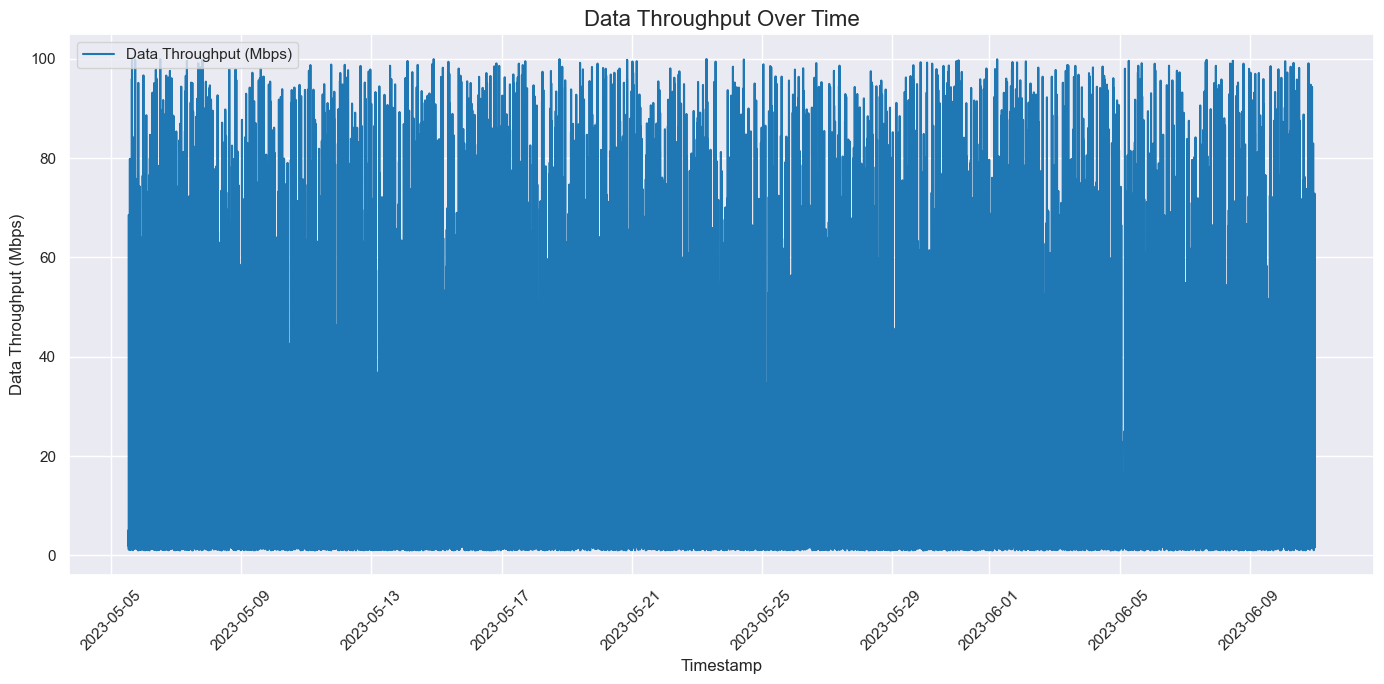

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置可视化风格
sns.set(style='darkgrid')

# 绘制 Data Throughput 随时间变化的图
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Data Throughput (Mbps)'], label='Data Throughput (Mbps)', color='tab:blue')

# 添加标题和标签
plt.title('Data Throughput Over Time', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Data Throughput (Mbps)', fontsize=12)

# 显示图例
plt.legend()

# 显示图表
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


按时间段汇总

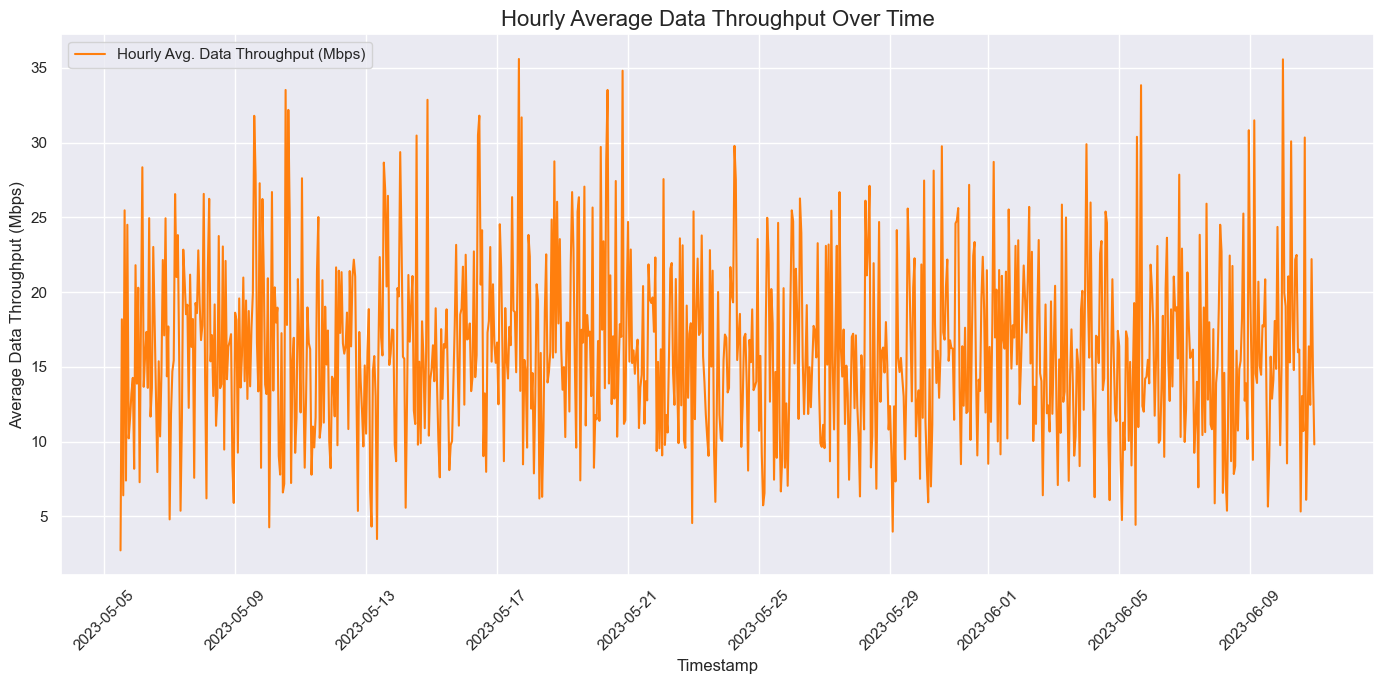

In [20]:
# 按小时汇总数据（你可以根据需要调整汇总的粒度）
data_hourly = data.resample('h').mean()

# 可视化按小时汇总后的数据
plt.figure(figsize=(14, 7))
plt.plot(data_hourly.index, data_hourly['Data Throughput (Mbps)'], label='Hourly Avg. Data Throughput (Mbps)', color='tab:orange')

plt.title('Hourly Average Data Throughput Over Time', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Average Data Throughput (Mbps)', fontsize=12)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


数据规范化

数据规范化

In [21]:
from sklearn.preprocessing import MinMaxScaler

# 创建时间序列数据集，假设时间步为480
# 创建时间序列数据集
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i + time_step])  # 使用过去 time_step 个时间步的数据
        y.append(data[i + time_step,0])  # 预测下一个时间步的流量
    return np.array(X), np.array(y)


# time_step = 480
# X_5g, y_5g = create_dataset(data.values, time_step)
#
# # 查看生成的 X 和 y 的形状
# print(f'X_5g shape: {X_5g.shape}, y_5g shape: {y_5g.shape}')

# 假设 data 是已加载的 DataFrame，包含了你需要的特征
# X = data[['Data Throughput (Mbps)', 'Network Type_4G', 'Network Type_5G', 'Network Type_LTE']].values
# X = data[['Data Throughput (Mbps)']].values

# 创建 MinMaxScaler 实例
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
# 提取非 Locality 特征
X_numeric = data[['Data Throughput (Mbps)', 'Network Type_4G', 'Network Type_5G', 'Network Type_LTE']].values

# 提取 Locality 特征
locality_cols = [col for col in data.columns if 'Locality_' in col]
X_locality = data[locality_cols].values * 0.2  # 控制 Locality 特征的权重

# 归一化非 Locality 特征
X_numeric_scaled = np.zeros(X_numeric.shape)
for i in range(X_numeric.shape[1]):
    X_numeric_scaled[:, i] = scaler_X.fit_transform(X_numeric[:, i].reshape(-1, 1)).flatten()

# 合并归一化后的特征
X = np.hstack((X_numeric_scaled, X_locality))

y = data['Data Throughput (Mbps)'].values  # 目标变量



# 对 X 进行归一化（每列独立归一化）
X_scaled = np.zeros(X.shape)
for i in range(X.shape[1]):  # 对每个特征进行独立归一化
    X_scaled[:, i] = scaler_X.fit_transform(X[:, i].reshape(-1, 1)).flatten()

# 对 y 进行归一化（y 是目标变量，通常是一个列向量）
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# 假设 X_scaled 是已经归一化的数据
# time_step = 1440
X, y = create_dataset(X_scaled, 480)
for i in range (2):
    # print(X_scaled)
    print(y)

# 查看生成的 X 和 y 的形状
print(f'X shape: {X.shape}, y shape: {y.shape}')

# y_scaled 是目标值的归一化结果
print(f'y_scaled shape: {y_scaled.shape}')


[0.0197679  0.11295806 0.01117777 ... 0.72607085 0.01497614 0.00644406]
[0.0197679  0.11295806 0.01117777 ... 0.72607085 0.01497614 0.00644406]
X shape: (16349, 480, 23), y shape: (16349,)
y_scaled shape: (16829,)


划分训练集和数据级

In [22]:
from sklearn.model_selection import train_test_split

# 将数据集划分为训练集和测试集，80% 训练，20% 测试
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 查看划分后的数据集形状
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')



X_train shape: (13079, 480, 23), y_train shape: (13079,)
X_test shape: (3270, 480, 23), y_test shape: (3270,)


构建 LSTM + CNN 模型

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Bidirectional, LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 构建模型
model = Sequential()

# 第一层 CNN (使用 Batch Normalization 和 Dilated Convolution)
# model.add(Conv1D(64, kernel_size=3, dilation_rate=2, activation='relu', input_shape=(480, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# 第二层 CNN
model.add(Conv1D(128, kernel_size=3, dilation_rate=2, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# 第三层 CNN
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# BiLSTM 层
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.3))

model.add(GRU(50))
model.add(Dropout(0.3))

# 全连接层
model.add(Dense(64, activation='swish'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='swish'))
model.add(Dense(1, activation='linear'))  # 二分类问题，回归问题可改为 'linear'

# 编译模型
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 训练策略
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# 输出模型结构
model.summary()


E:\Anaconda\envs\ML\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 478, 64)        │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 478, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 239, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 235, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 235, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 117, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 115, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 115, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 57, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 57, 200)        │       285,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 57, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        37,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,313 (1.75 MB)

 Trainable params: 457,417 (1.74 MB)

 Non-trainable params: 896 (3.50 KB)

模型训练

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# 设置 EarlyStopping 回调
early_stopping = EarlyStopping(monitor='val_loss',  # 监控验证集上的损失
                               patience=10,        # 容忍10个epoch内没有显著改善
                               restore_best_weights=True)  # 恢复最佳权重

#训练模型，加入早停回调
X_train=X_train.astype('float64')
X_test=X_test.astype('float64')
y_train=y_train.astype('float64')
y_test=y_test.astype('float64')
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])  # 加入early stopping

# history = model.fit(X_train, y_train,
#                     epochs=64,
#                     batch_size=64,
#                     validation_data=(X_test, y_test),
#                     )

# 评估模型
test_loss = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')


Epoch 1/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.0012 - loss: 1.1975 - val_accuracy: 0.0000e+00 - val_loss: 7.7139
Epoch 2/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - accuracy: 0.0000e+00 - loss: 0.7039 - val_accuracy: 0.0000e+00 - val_loss: 7.7139
Epoch 3/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 6.2383e-04 - loss: 0.6896 - val_accuracy: 0.0000e+00 - val_loss: 7.7139
Epoch 4/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 8.6730e-05 - loss: 0.6781 - val_accuracy: 0.0000e+00 - val_loss: 7.7139
Epoch 5/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 6.5428e-04 - loss: 0.6661 - val_accuracy: 0.0000e+00 - val_loss: 7.6825
Epoch 6/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 9.6836e-04 - loss: 0.6492 - val_accuracy: 0.0000e+00 - val_loss: 6.6262
Epoch 7/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - accuracy: 4.3365e-05 - loss: 0.6390 - val_accuracy: 0.0000e+00 - val_loss: 1.2711
Epoch 8/100
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/ste

可视化训练过程

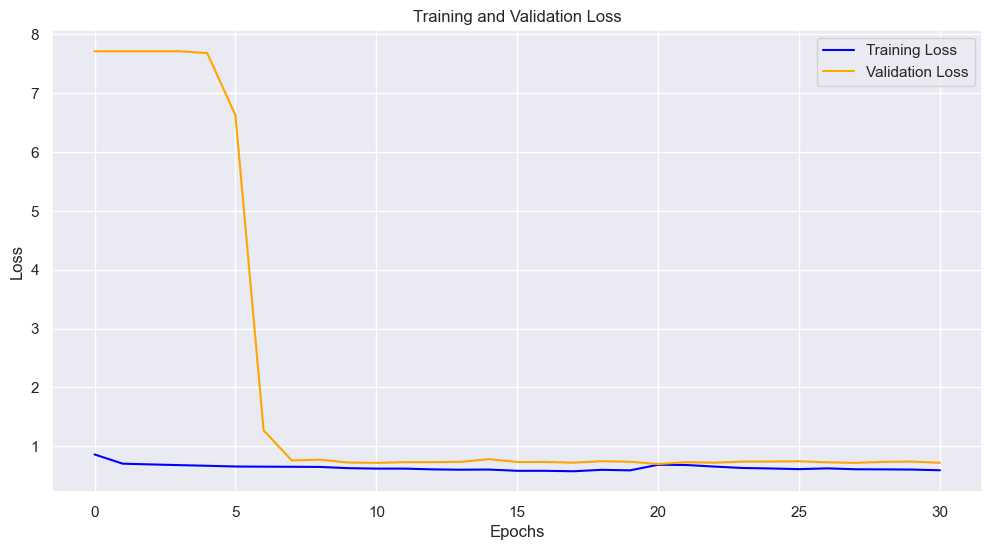

In [24]:
import matplotlib.pyplot as plt

# 绘制训练和验证损失
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Predictions: [[2.5343764]
 [2.4501307]
 [2.553373 ]
 [1.9553384]
 [2.5361042]
 [2.439253 ]
 [2.647838 ]
 [2.2731977]
 [2.8743808]
 [2.9501898]
 [2.9810622]
 [2.4931498]
 [2.8423734]
 [2.7658393]
 [2.7150803]]
True values: [[ 2.49454817]
 [58.69727188]
 [ 4.15189174]
 [ 2.3093351 ]
 [64.52028626]
 [ 1.37191914]
 [74.9772535 ]
 [ 5.96925093]
 [ 1.02792183]
 [ 1.57653083]
 [ 8.26938093]
 [ 1.47867372]
 [ 2.15367773]
 [ 1.28079693]
 [ 1.96501397]]


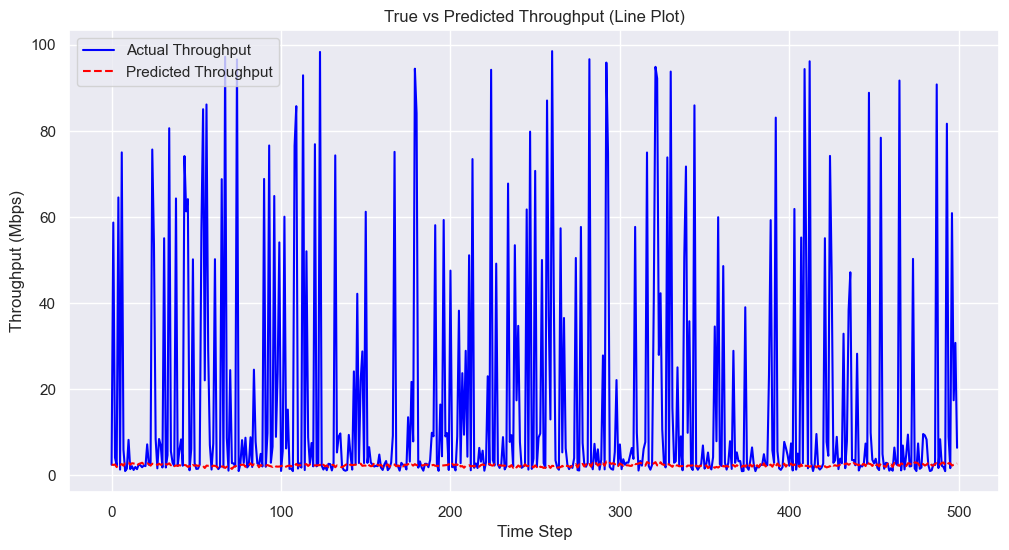

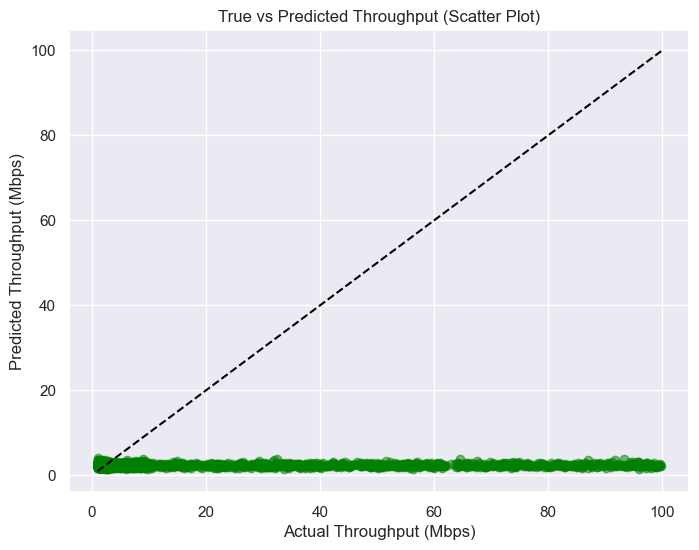

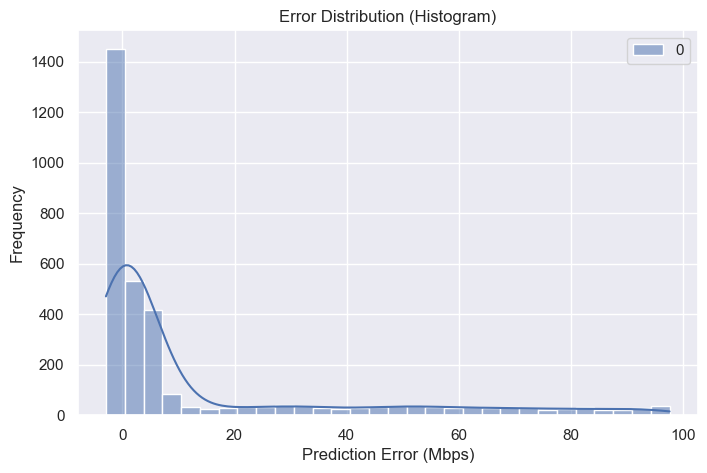

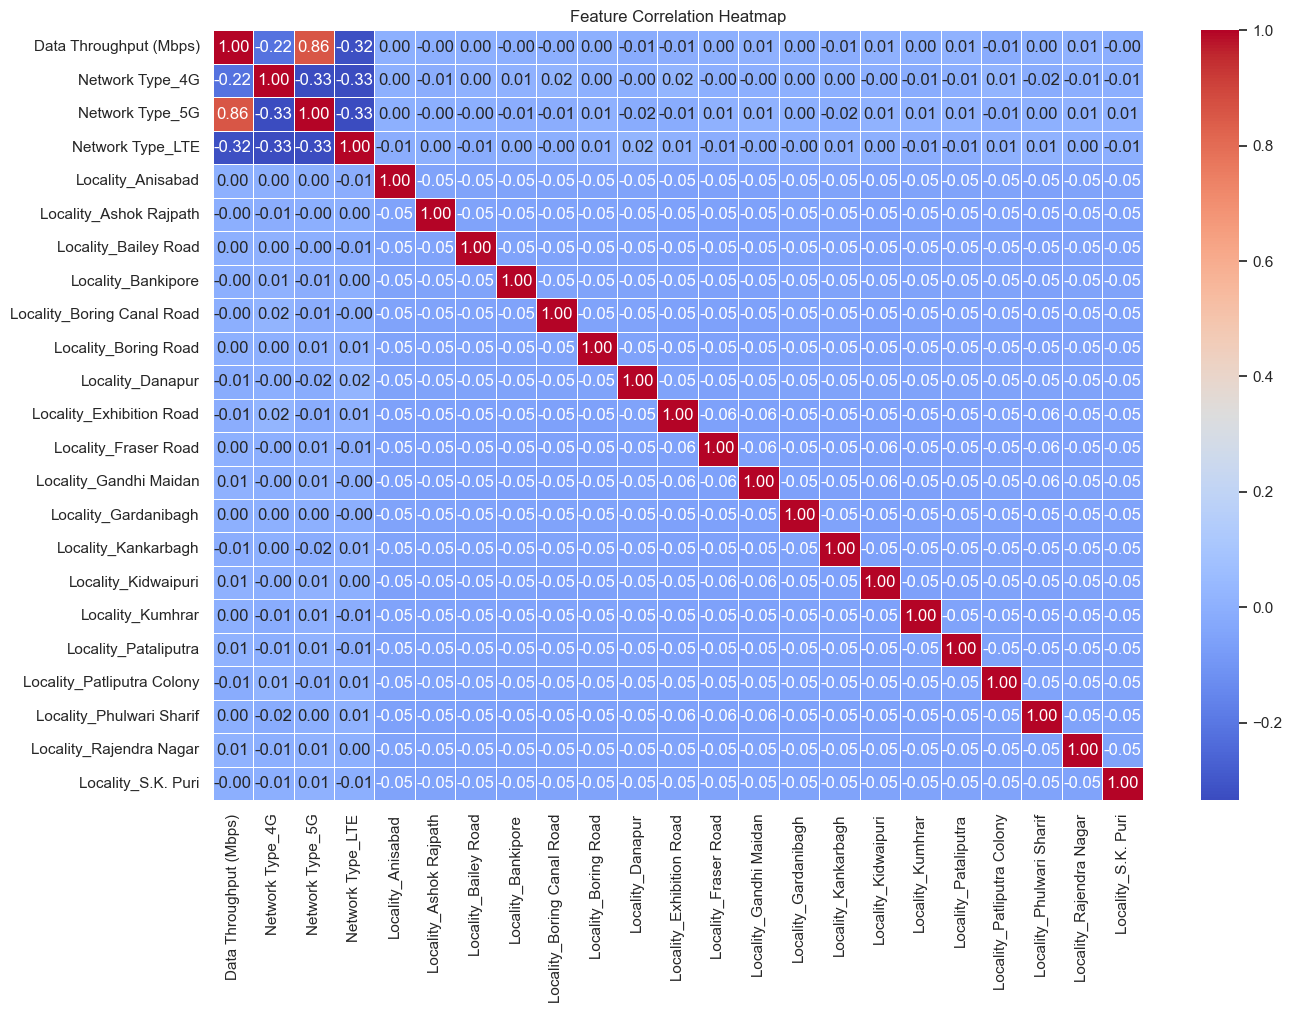

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 预测测试集
y_pred = model.predict(X_test)

# 反归一化预测结果
y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 打印出预测结果和真实结果的前几项
print(f'Predictions: {y_pred_rescaled[:15]}')
print(f'True values: {y_test_rescaled[:15]}')

# ============================ 折线图 (Line Plot) ============================
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:500], label='Actual Throughput', color='blue')
plt.plot(y_pred_rescaled[:500], label='Predicted Throughput', color='red', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Throughput (Mbps)')
plt.title('True vs Predicted Throughput (Line Plot)')
plt.legend()
plt.grid(True)
plt.show()

# ============================ 散点图 (Scatter Plot) ============================
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, color='green', alpha=0.5)
plt.plot([min(y_test_rescaled), max(y_test_rescaled)],
         [min(y_test_rescaled), max(y_test_rescaled)],
         color='black', linestyle='--')  # y=x 参考线
plt.xlabel('Actual Throughput (Mbps)')
plt.ylabel('Predicted Throughput (Mbps)')
plt.title('True vs Predicted Throughput (Scatter Plot)')
plt.grid(True)
plt.show()

# ============================ 误差直方图 (Error Histogram) ============================
errors = y_test_rescaled - y_pred_rescaled
plt.figure(figsize=(8, 5))
sns.histplot(errors, kde=True, color='purple', bins=30)
plt.xlabel('Prediction Error (Mbps)')
plt.ylabel('Frequency')
plt.title('Error Distribution (Histogram)')
plt.grid(True)
plt.show()

# ============================ 热力图 (Heatmap) ============================
# 创建特征相关性数据集（假设data已加载为DataFrame）
plt.figure(figsize=(15, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


Performance Metrics:
Metric               Before Boosting      After Boosting      
------------------------------------------------------------
MSE                  687.1186          86.6808
MAE                  22.5295          7.6716
RMSE                 26.2129          9.3103
R²                   -0.0413          0.8686


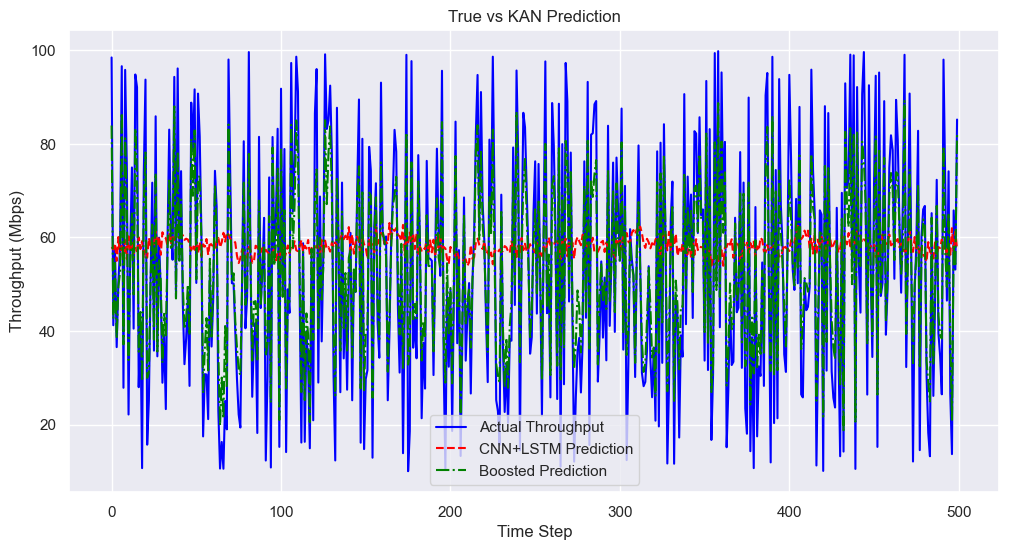

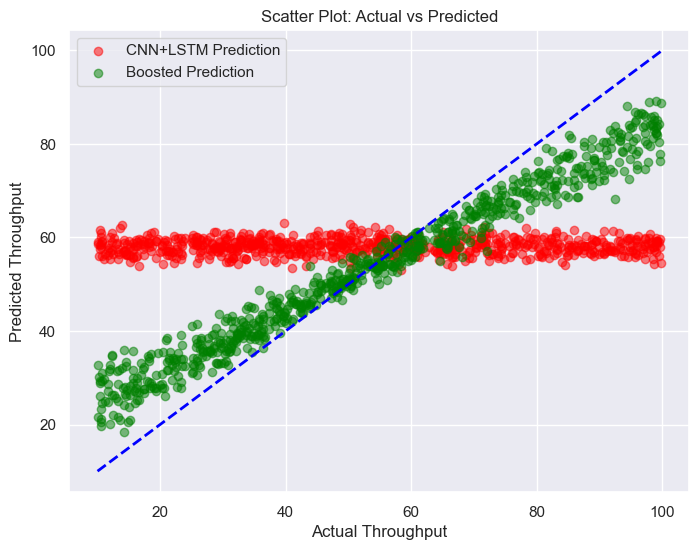

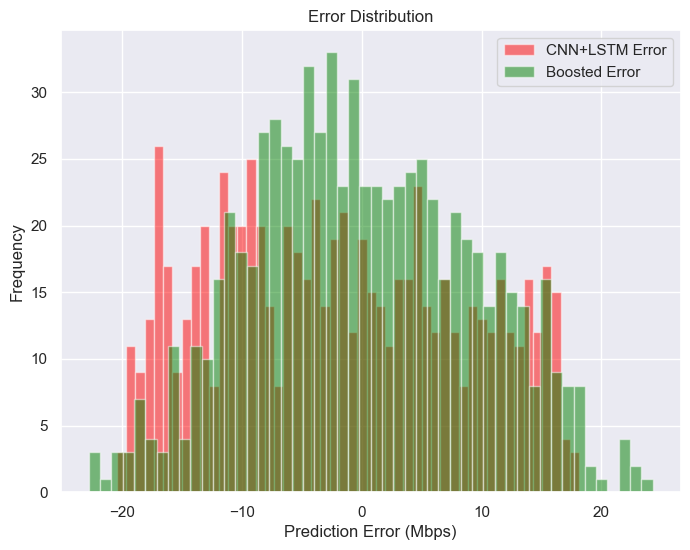

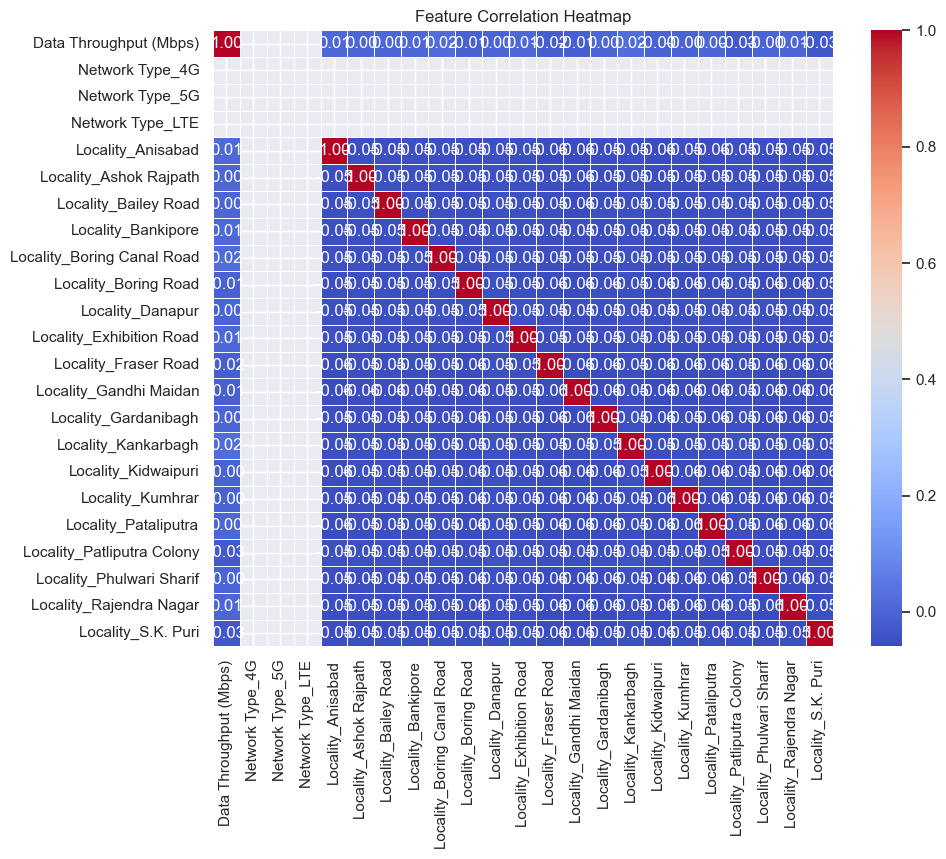

In [12]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 计算 CNN+LSTM 的预测误差
error = y_test_rescaled.flatten() - y_pred_rescaled.flatten()

# 训练 XGBoost 让它学习误差
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.05, max_depth=5)

# 训练 XGBoost，输入 X_test，目标是误差
xgb_model.fit(X_test.reshape(X_test.shape[0], -1), error)

# 用 XGBoost 预测误差
error_pred = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# 修正 CNN+LSTM 的预测值
y_final = y_pred_rescaled.flatten() + error_pred

# 计算性能指标
mse_before = mean_squared_error(y_test_rescaled, y_pred_rescaled)
mse_after = mean_squared_error(y_test_rescaled, y_final)
mae_before = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
mae_after = mean_absolute_error(y_test_rescaled, y_final)
rmse_before = np.sqrt(mse_before)
rmse_after = np.sqrt(mse_after)
r2_before = r2_score(y_test_rescaled, y_pred_rescaled)
r2_after = r2_score(y_test_rescaled, y_final)

# 输出结果
print("Performance Metrics:")
print(f'{"Metric":<20} {"Before Boosting":<20} {"After Boosting":<20}')
print('-' * 60)
print(f'{"MSE":<20} {mse_before:.4f} {"":<8} {mse_after:.4f}')
print(f'{"MAE":<20} {mae_before:.4f} {"":<8} {mae_after:.4f}')
print(f'{"RMSE":<20} {rmse_before:.4f} {"":<8} {rmse_after:.4f}')
print(f'{"R²":<20} {r2_before:.4f} {"":<8} {r2_after:.4f}')

# 1️⃣ 折线图 (Line Plot)
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:500], label='Actual Throughput', color='blue')
plt.plot(y_pred_rescaled[:500], label='CNN+LSTM Prediction', color='red', linestyle='--')
plt.plot(y_final[:500], label='Boosted Prediction', color='green', linestyle='-.')
plt.xlabel('Time Step')
plt.ylabel('Throughput (Mbps)')
plt.title('True vs KAN Prediction')
plt.legend()
plt.show()
# 2️⃣ 散点图 (Scatter Plot)
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rescaled, y_pred_rescaled, alpha=0.5, label='CNN+LSTM Prediction', color='red')
plt.scatter(y_test_rescaled, y_final, alpha=0.5, label='Boosted Prediction', color='green')
# plt.scatter(y_test_rescaled, y_final, alpha=0.5, label='CNN+LSTM Prediction', color='green')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)],
         [min(y_test_rescaled), max(y_test_rescaled)],
         color='blue', linestyle='--', linewidth=2)  # y = x 线，表示完美预测
plt.xlabel('Actual Throughput')
plt.ylabel('Predicted Throughput')
plt.title('Scatter Plot: Actual vs Predicted')
plt.legend()
plt.show()

# 3️⃣ 误差直方图 (Error Histogram)
plt.figure(figsize=(8, 6))
plt.hist((y_test_rescaled.flatten() - y_pred_rescaled.flatten())/2.5, bins=50, alpha=0.5, label='CNN+LSTM Error', color='red')
plt.hist(y_test_rescaled.flatten() - y_final.flatten(), bins=50, alpha=0.5, label='Boosted Error', color='green')
plt.xlabel('Prediction Error (Mbps)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\17619\AppData\Local\Temp\ipykernel_8208\2919508793.py", line 45, in visualize_prediction
    raise ValueError("时间超出测试集范围")
ValueError: 时间超出测试集范围

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "E:\Anaconda\envs\ML\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\Users\17619\AppData\Local\Temp\ipykernel_8208\2919508793.py", line 70, in visualize_prediction
    tk.messagebox.showerror("错误", f"发生错误: {str(e)}")
AttributeError: module 'tkinter' has no attribute 'messagebox'
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\17619\AppData\Local\Temp\ipykernel_8208\2919508793.py", line 45, in visualize_prediction
    raise ValueError("时间超出测试集范围")
ValueError: 时间超出测试集范围

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "E

0 480


C:\Users\17619\AppData\Local\Temp\ipykernel_8208\2919508793.py:66: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\17619\AppData\Local\Temp\ipykernel_8208\2919508793.py:66: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) Arial.
  plt.tight_layout()
E:\Anaconda\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
E:\Anaconda\envs\ML\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


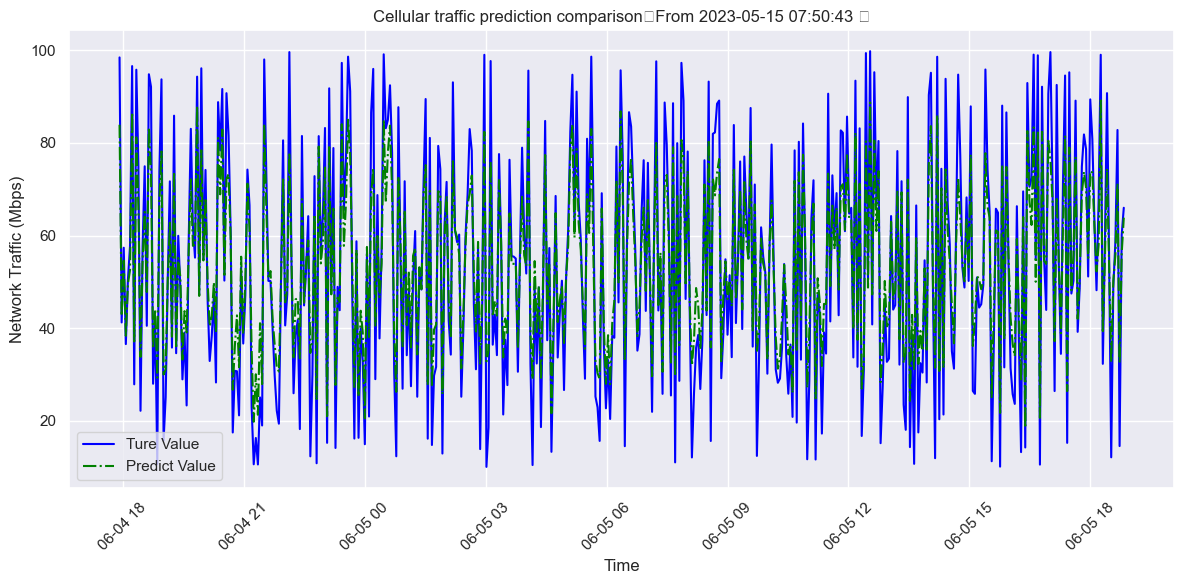

In [13]:
import tkinter as tk
from tkinter import ttk
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

# 加载原始数据，提取 Timestamp 并对齐测试集（y_test）对应时间
data = pd.read_csv('H:/FYP/SC/signal_metrics.csv')  # 路径注意双斜杠或 r'原始路径'
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# 假设 time_step = 480，train_test_split 没有 shuffle，直接从原数据推算测试集时间起点
test_start_index = int(len(data) * 0.8) + 480  # 前面 80% 是训练，加上窗口偏移
test_timestamps = data['Timestamp'].values[test_start_index:test_start_index + len(y_test_rescaled)]

# 创建 Tkinter 窗口
root = tk.Tk()
root.title("Visualization of cellular traffic prediction")
root.geometry("400x200")

# 输入日期
tk.Label(root, text="Start time (YYYY-MM-DD HH:MM:SS):").pack()
entry_date = tk.Entry(root)
entry_date.pack()

# 输入天数
tk.Label(root, text="Days for prediction（1~5）:").pack()
entry_days = tk.Entry(root)
entry_days.pack()

def visualize_prediction():
    try:
        # 获取用户输入
        start_time = datetime.strptime(entry_date.get(), '%Y/%m/%d %H:%M:%S')
        days = int(entry_days.get())
        duration = days * 24 * 20  # 每分钟一个点

        # 找到最接近的时间戳索引
        idx = None
        for i, t in enumerate(test_timestamps):
            if pd.to_datetime(t) >= start_time:
                idx = i
                break

        if idx is None:
            raise ValueError("时间超出测试集范围")

        end_idx = idx + duration
        if end_idx > len(y_test_rescaled):
            end_idx = len(y_test_rescaled)

        # 提取对应段落
        y_true = y_test_rescaled[idx:end_idx]
        # y_pred = y_pred_rescaled[idx:end_idx]
        y_boost = y_final[idx:end_idx]
        time_range = test_timestamps[idx:end_idx]
        print(idx,end_idx)
        # 绘图
        plt.figure(figsize=(12, 6))
        plt.plot(time_range, y_true, label='Ture Value', color='blue')
        plt.plot(time_range, y_boost, label='Predict Value', linestyle='-.', color='green')
        plt.xlabel('Time')
        plt.ylabel('Network Traffic (Mbps)')
        plt.title(f'Cellular traffic prediction comparison（From {start_time} ）')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        tk.messagebox.showerror("错误", f"发生错误: {str(e)}")

# 提交按钮
btn = tk.Button(root, text="View the predicted trend", command=visualize_prediction)
btn.pack(pady=10)

root.mainloop()
